# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import utils


from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import integrated_brier_score
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer
from sksurv.datasets import load_gbsg2
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

from lifelines import CoxPHFitter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import survtreeshap as sts

from survshap import SurvivalModelExplainer, PredictSurvSHAP

import importlib


importlib.reload(sts)

/home/ducrot/miniconda3/envs/env_survtreeshap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'survtreeshap' from '/home/ducrot/survtreeshap/survtreeshap.py'>

# GBSG Data loading

In [2]:


X, y = load_gbsg2()
X = X.copy()



In [3]:
# One-hot encoding
categorial_columns = ["horTh", "menostat", "tgrade"]
encoder = OneHotEncoder()
encoder.fit(X[categorial_columns])
X_encoded = encoder.fit_transform(X[categorial_columns]).toarray()
new_column_names = encoder.get_feature_names_out(categorial_columns)
X_encoded_df = pd.DataFrame(X_encoded, columns=new_column_names)

# remove useless columns
#X_final = X_filtred.drop(columns=categorial_columns).join(X_encoded_df).drop(columns=['id', 't.start', 't.stop', 'event'])

X_encoded_df.head()

X_encoded_df = X_encoded_df.drop(columns=['menostat_Pre', 'horTh_no', 'tgrade_I'])
X_red = X.drop(columns=['horTh','menostat','tgrade'])

X_encoded_df = pd.concat([X_encoded_df, X_red], axis=1)
X_encoded_df

,horTh_yes,menostat_Post,tgrade_II,tgrade_III,age,estrec,pnodes,progrec,tsize
0,0.0,1.0,1.0,0.0,70.0,66.0,3.0,48.0,21.0
1,1.0,1.0,1.0,0.0,56.0,77.0,7.0,61.0,12.0
2,1.0,1.0,1.0,0.0,58.0,271.0,9.0,52.0,35.0
3,1.0,1.0,1.0,0.0,59.0,29.0,4.0,60.0,17.0
4,0.0,1.0,1.0,0.0,73.0,65.0,1.0,26.0,35.0
...,...,...,...,...,...,...,...,...,...
681,0.0,0.0,0.0,1.0,49.0,84.0,3.0,1.0,30.0
682,1.0,1.0,0.0,1.0,53.0,0.0,17.0,0.0,25.0
683,0.0,0.0,0.0,1.0,51.0,0.0,5.0,43.0,25.0
684,0.0,1.0,1.0,0.0,52.0,34.0,3.0,15.0,23.0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded_df, y, test_size=0.2, random_state=42
)

# CPH and RSF models

In [5]:
# 5. Cox Proportional Hazards Model
cox_model = CoxPHSurvivalAnalysis()
cox_model.fit(X_encoded_df, y)
cox_pred = cox_model.predict(X_encoded_df)
cindex_cox = concordance_index_censored(y["cens"], y["time"], cox_pred)[0]



In [6]:

coefficients = pd.Series(cox_model.coef_, index=X_train.columns)

print(coefficients.sort_values(ascending=False))

tgrade_III       0.779350
tgrade_II        0.635979
menostat_Post    0.258157
pnodes           0.048782
tsize            0.007798
estrec           0.000198
progrec         -0.002217
age             -0.009453
horTh_yes       -0.346242
dtype: float64


In [7]:
# 6. Random Survival Forest
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=5, n_jobs=-1, random_state=42)
rsf.fit(X_encoded_df, y)
rsf_pred = rsf.predict(X_encoded_df)
cindex_rsf = concordance_index_censored(y["cens"], y["time"], rsf_pred)[0]



# C-index and Integrated Brier Score comparison

In [8]:
# 7. Résultats
print(f"C-index CoxPH: {cindex_cox:.3f}")
print(f"C-index RSF:   {cindex_rsf:.3f}")

C-index CoxPH: 0.692
C-index RSF:   0.850


In [9]:
from sksurv.metrics import integrated_brier_score
import numpy as np

# 1. Définir une grille de temps pour l'IBS
times_ibs = np.percentile(y["time"], np.linspace(10, 90, 100))

# 2. Estimations de survie des modèles

# Cox model : prédictions de fonctions de survie
cox_surv_funcs = cox_model.predict_survival_function(X_encoded_df)
cox_surv_preds = np.row_stack([fn(times_ibs) for fn in cox_surv_funcs])

# RSF model : prédictions de fonctions de survie
rsf_surv_funcs = rsf.predict_survival_function(X_encoded_df)
rsf_surv_preds = np.row_stack([fn(times_ibs) for fn in rsf_surv_funcs])

# 3. Calcul de l'Integrated Brier Score
ibs_cox = integrated_brier_score(y, y, cox_surv_preds, times_ibs)
ibs_rsf = integrated_brier_score(y, y, rsf_surv_preds, times_ibs)

# 4. Affichage des résultats
print(f"Integrated Brier Score (CoxPH): {ibs_cox:.3f}")
print(f"Integrated Brier Score (RSF):   {ibs_rsf:.3f}")


Integrated Brier Score (CoxPH): 0.181
Integrated Brier Score (RSF):   0.113


/tmp/ipykernel_6687/3477374388.py:11: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  cox_surv_preds = np.row_stack([fn(times_ibs) for fn in cox_surv_funcs])
/tmp/ipykernel_6687/3477374388.py:15: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  rsf_surv_preds = np.row_stack([fn(times_ibs) for fn in rsf_surv_funcs])


# Kernel SurvSHAP(t) explanation

In [11]:
if True:
    # create explainer
    explainer = SurvivalModelExplainer(model = rsf, data = X_encoded_df, y = y)

    # compute SHAP values for a single instance
    observation_A = X_encoded_df.iloc[[2]]
    start_time = time.time()
    survshap_A = PredictSurvSHAP()
    
    survshap_A.fit(explainer = explainer, new_observation = observation_A)
    elapsed_time = time.time() - start_time  # ⏱️ fin du chronométrage
    print(f"Execution time: {elapsed_time:.2f} seconds")

    
   



Execution time: 51.14 seconds


In [12]:
df=survshap_A.result 
# On sélectionne les colonnes temporelles (celles qui commencent par "t =")
time_cols = [col for col in df.columns if col.startswith("t =")]

# On convertit ces colonnes en float pour les trier correctement
time_values = [float(col.replace("t = ", "")) for col in time_cols]

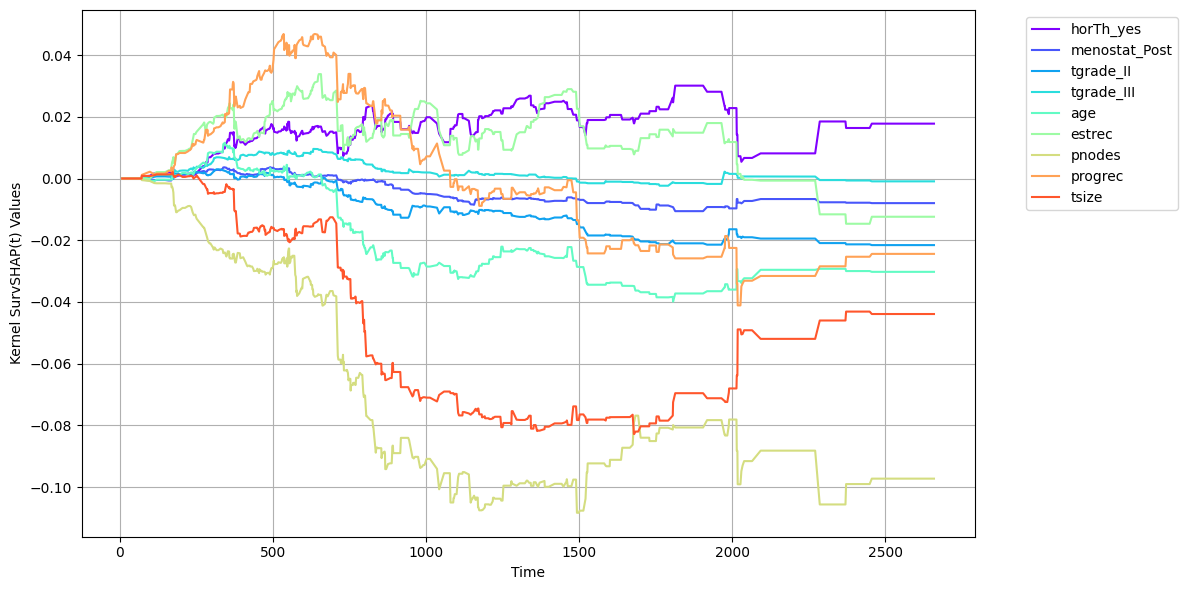

In [13]:

cmap = plt.get_cmap('rainbow')  # ou 'nipy_spectral', 'plasma', etc.
colors = [cmap(i / 9) for i in range(9)]
plt.figure(figsize=(12, 6))

for i, row in df.iterrows():
    contribs = row[time_cols].values.astype(float)
    plt.plot(time_values, contribs, label=row["variable_name"], color=colors[i])

plt.xlabel("Time")
plt.ylabel("Kernel SurvSHAP(t) Values")
#plt.title("All SurvSHAP values")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.plot()
plt.savefig("GBSG1patient_kernelSurvSHAP.pdf", format="pdf",dpi=300, bbox_inches="tight")


# SurvTreeSHAP(t) explanation

100%|████████████████████████████████████████████████████████████████████████████████| 574/574 [00:02<00:00, 229.88it/s]


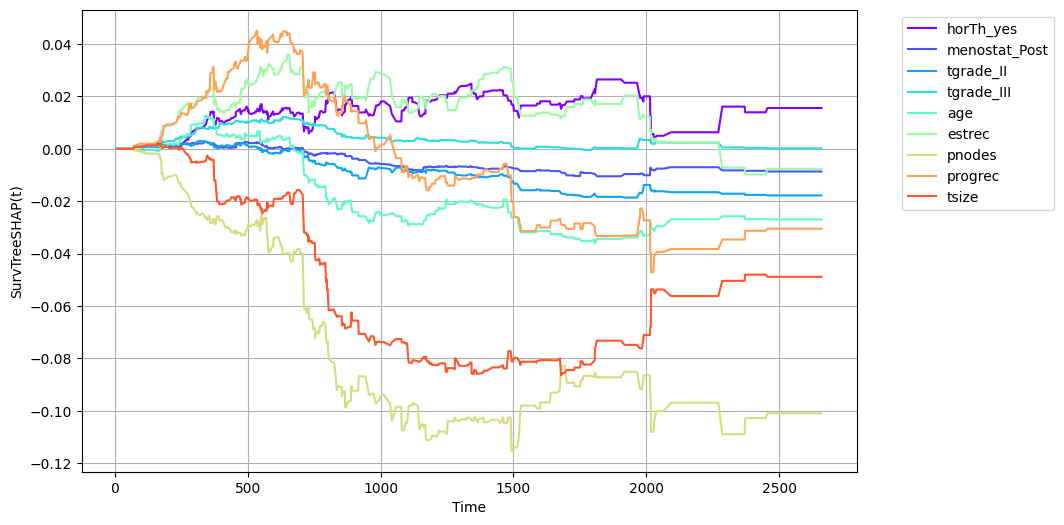

In [14]:

STS_com= sts.SurvTreeSHAPexplainer(rsf, X_encoded_df)
STS_com.plotgraph(2)

100%|█████████████████████████████████████████████████████████████████████████████████| 686/686 [27:09<00:00,  2.37s/it]


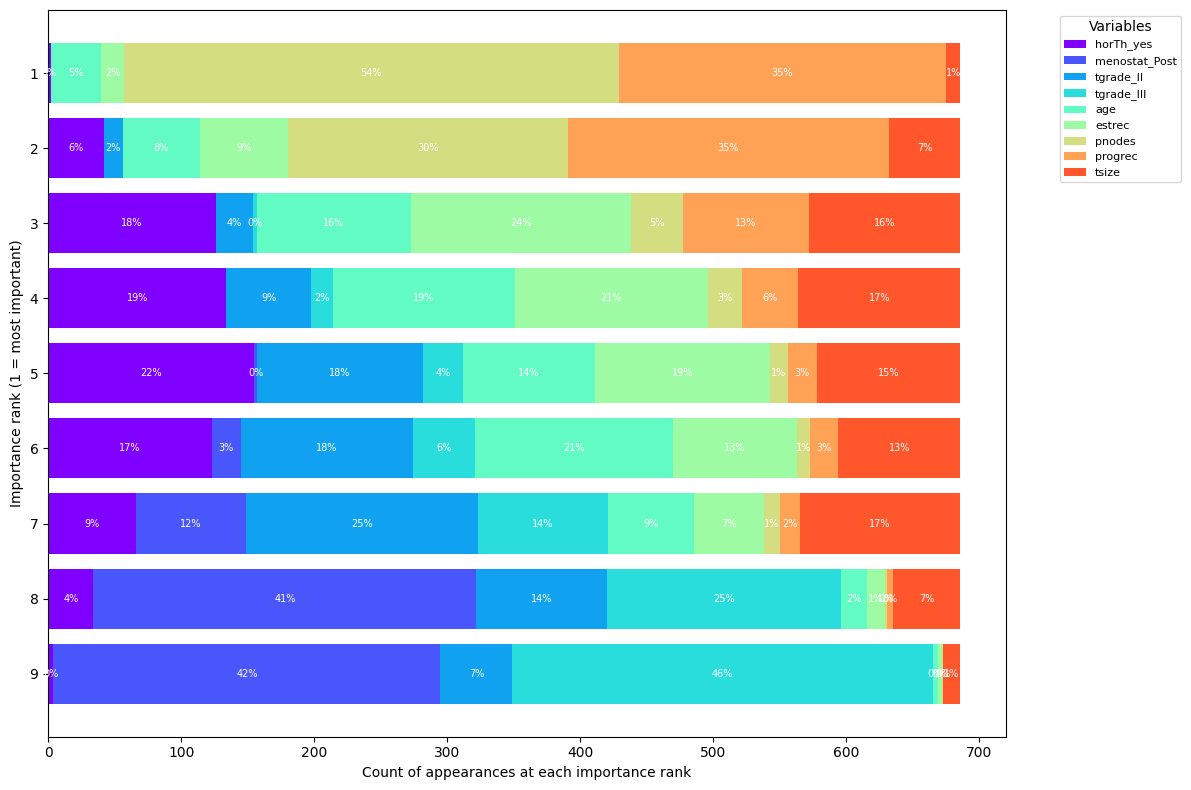

Execution time: 1629.21 seconds


In [16]:
STS_com.rankvariables(1000)